In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

__Подготовка данных, выравниваем столбцы москвичей и не-москвичей__

In [3]:
df = pd.read_csv('traffic_moscow.csv', header=None)
df.columns = ["i", "j", "amt", "t", "s"]

def make_index(i, j):
    residents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    if int(i) in residents:
        return 1 # живут в Москве
    else:
        return 0 # живут в области

df['r'] = df.apply(lambda row: make_index(row['i'], 
        row['j']), axis=1) # добавили столбец принадлежности москвичам

def amt_for_residents(df): # умножили значения москвичей на 1.62
    for i in range(df.shape[0]):
        df.loc[i, 'amt'] *= 1.62 if df.loc[i, 'r'] == 1 else 1
    return df

# df = amt_for_residents(df)

In [4]:
df.head()

,i,j,amt,t,s,r
0,1,1,40,26,2.2,1
1,1,2,4,49,8.1,1
2,1,3,3,35,6.8,1
3,1,4,2,75,9.3,1
4,1,5,2,30,8.0,1


__Инициализируем матрицу издержек T, матрицу d, L и W__

In [5]:
def costs_func(i, j, column):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    c = columns[column]
    try:
        c = int(c)
        return c
    except TypeError: # если не пересекается район i с районом j
        return 0
    
def f_T(T, alpha):
    return np.exp(alpha * T)

def create_T_d():
    T = np.zeros((22, 22))
    d = np.zeros((22, 22))
    for i in range(0, 22):
        for j in range(0, 22):
            T[i][j] = costs_func(i, j, 't')
            d[i][j] = costs_func(i, j, 'amt')
    return T, d

In [6]:
L_i = df.groupby('i')['amt'].sum().reset_index()
W_j = df.groupby('j')['amt'].sum().reset_index()

W = W_j.as_matrix()[:, [1]]
L = L_i.as_matrix()[:, [1]]    
    
total_i = L_i['amt'].sum()
total_j = W_j['amt'].sum()

print(total_i, total_j) # проверили что правильно нашли L и W

T, d = create_T_d()

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


1965 1965


__Итерирующая функция. Исполнена в векторной форме. Подглядела в отчёте Сергея Павлова__

In [7]:
def iterate(A, B, W, L, f, n):
    A_p = (1.0 / ((B.T * W.T * f).sum(axis = 1))).reshape((n,1))
    B_p = (1.0 / ((A_p * L * f).sum(axis = 0))).T.reshape((n,1))
    return A_p, B_p

In [8]:
def gravity_func(alpha, iterations):

    A = np.ones((22,1))
    B = np.ones((22,1))
    
    dA = []
    dB = []
    f_a = np.exp(-alpha * T)
    
    for i in range(iterations):
        
        A_n, B_n = iterate(A,B,W,L,f_a,22)
        
        dA_ = np.linalg.norm(A_n, 2) - np.linalg.norm(A, 2) 
            # два норма -- корень из суммы квадратов, ищем невязку
        dB_ = np.linalg.norm(B_n, 2) - np.linalg.norm(B, 2)
        
        dA.append(dA_)
        dB.append(dB_)
        
        A, B = A_n, B_n

    gr_fun = np.dot((A * L) , (B * W).T) * f_a
    return A, B, dA, dB, gr_fun

__Смотрим за сколько итераций сойдутся A и B. Сошлось за 2500 примерно__

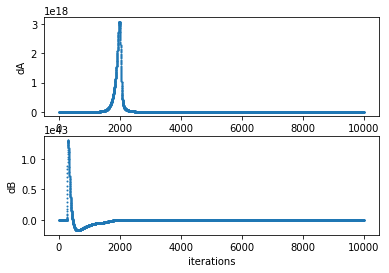

In [9]:
A, B, dA, dB, _ = gravity_func(5, 10000)

plt.subplot(2, 1, 1)
plt.scatter(range(20, 10000), dA[20:], s = 1)
plt.ylabel('dA')

plt.subplot(2, 1, 2)
plt.scatter(range(20, 10000), dB[20:], s = 1)
plt.ylabel('dB')
plt.xlabel('iterations')

plt.show()

__Подбираем оптимальное $\alpha$. Рассматриваем отрезок [0, 0.5]__

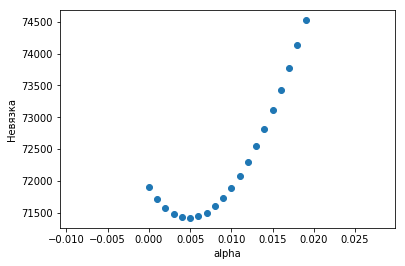

In [10]:
res = []
for alpha in np.arange(0.0, 0.02, 0.001):
    _, _, _, _, r = gravity_func(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.scatter(np.arange(0.0, 0.02, 0.001), res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

__Просто Синхорн, но теперь через $\lambda$, а не A и B__

In [11]:
def Sinkhorn(k, lambda_W_prev, lambda_L_prev):
    summa = 0
    
    lambda_L = np.zeros((n, ), dtype=float)
    lambda_W = np.zeros((n, ), dtype=float)
    
    if k % 2 == 0:
        for i in range(n):
            for j in range(n):
                summa += ( np.exp(-lambda_W_prev[j]) / 
                            L[i] * np.exp(1 + beta * alpha * T[i][j]) )
            lambda_L[i] = np.log(summa)
            summa = 0
        lambda_W = lambda_W_prev
    else:
        for j in range(n):
            for i in range(n):
                summa += ( np.exp(-lambda_L_prev[i]) / 
                            W[j] * np.exp(1 + beta * alpha * T[i][j]) )
            lambda_W[j] = np.log(summa)
            summa = 0
        lambda_L = lambda_L_prev
#         print(lambda_W, lambda_L)
    return lambda_W, lambda_L

def iterate(beta, alpha, d, L, W, num_iter):
    
    lambda_L = np.zeros((n, ), dtype=float)
    lambda_W = np.zeros((n, ), dtype=float)
    
    dL = []
    dW = []
    
    for k in range(num_iter):
        
        lambda_Wn, lambda_Ln = Sinkhorn(k, lambda_W, lambda_L)
        
        dL_ = np.linalg.norm(lambda_L - lambda_Ln, 2)/np.linalg.norm(lambda_L, 2) 
        dW_ = np.linalg.norm(lambda_W - lambda_Wn, 2)/np.linalg.norm(lambda_W, 2)
        
        dL.append(dL_)
        dW.append(dW_)
        
        lambda_L, lambda_W = lambda_Ln, lambda_Wn 
        
#     print(lambda_L, '\n', lambda_W)
    r = error_d_i_j(lambda_L, lambda_W, d, beta, alpha)
    
    return r, dL, dW

def error_d_i_j(lambda_L, lambda_W, d, beta, alpha):
    summa = 0
    for i in range(n):
        for j in range(n):
            summa += (d[i][j] - np.exp(-lambda_L[i])*np.exp(-lambda_W[j]) / 
                      np.exp(1 + beta*alpha*T[i][j]))**2
    return summa

__Смотрим лямбды__

In [12]:
num_iter = 2500
alpha, beta = 1.0, 1.0
n = 22

L_i = df.groupby('i')['amt'].sum().reset_index()
W_j = df.groupby('j')['amt'].sum().reset_index()

W = W_j.as_matrix()[:, 1]
L = L_i.as_matrix()[:, 1]

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


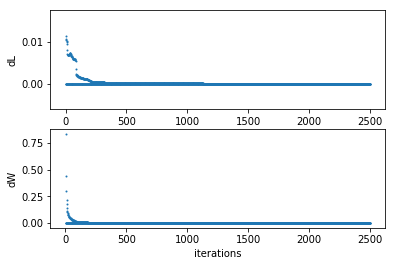

In [13]:
_, dL, dW = iterate(beta, alpha, d, L, W, num_iter)

plt.subplot(2, 1, 1)
plt.scatter(range(num_iter), dL, s = 1)
plt.ylabel('dL')

plt.subplot(2, 1, 2)
plt.scatter(range(num_iter), dW, s = 1)
plt.ylabel('dW')
plt.xlabel('iterations')

plt.show()

In [14]:
num_iter = 1500
alpha = 1.0
beta_range = np.arange(0.0, 1.0, 0.1)
res_list = []
for beta in beta_range:
    r, _, _ = iterate(beta, alpha, d, L, W, num_iter)
    res_list.append(r)
#     print(r, beta)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


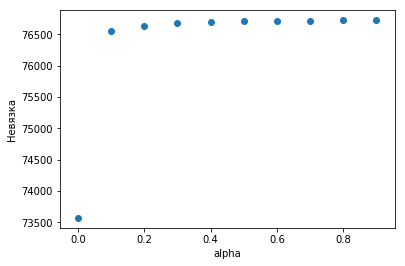

In [15]:
plt.scatter(beta_range, res_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

In [ ]:
num_iter = 1500
alpha = 1.0
beta_range = np.arange(0.0, 0.1, 0.01)
res_list = []

for beta in beta_range:
    r, _, _ = iterate(beta, alpha, d, L, W, num_iter)
    res_list.append(r)
#     print(r, beta)

In [ ]:
plt.scatter(beta_range, res_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

In [ ]:
def fast_Sinkhorn(k, x, L, alpha, beta, num_iter):
    a_n = 0
    a = 0
    
    L = 1
    L_n = L / 2
    
    y = np.zeros((2*n, ), dtype=float)
    y_n = np.zeros((2*n, ), dtype=float)
    
    V = np.zeros((2*n, ), dtype=float)
    V_n = np.zeros((2*n, ), dtype=float)
    
    x = np.zeros((2*n, ), dtype=float)
    x_n = np.zeros((2*n, ), dtype=float)
    
    tau = 0
    tau_k = 0
    
    for k in range(num_iter):
        while True:
            a_n = 1 / 2*L + np.sqrt( 1 / 4 * (L**2) + (a**2)* L / L_n)
            tau_k = 1 / a_n
            y_n = tau_k * V_n + (1 - tau_n)*x_n
            if k % 2 == 0:
                summa = 0
                for i in range(n):
                    for j in range(n):
                        summa += (np.exp(-y_n[n:][j]) / 
                        L[i] * np.exp(1 + beta * alpha * T[i][j]) )
                    y_n[n:][i] = summa
                x_n = np.concatenate((y_1, y_2), axis = 0)
            else:
                summa = 0
                for j in range(n):
                    for i in range(n):
                        summa += (np.exp(-y_n[:n][i]) / 
                        W[j] * np.exp(1 + beta * alpha * T[j][i]) )
                    y_n[:n][j] = summa
                x_n = np.concatenate((y_1, y_2), axis = 0)
                
            phi_v = (y_n[n:], y_n[:n], beta, alpha, L, W)
            V_n = V - a_n*np.gradient(phi_v)
            
    return 0

In [ ]:
v_1 = np.array([0,0,0,0,0])
v_2 = np.array([1,1,1,1,1])
v_3 = np.concatenate((v_1, v_2), axis=0)

In [ ]:
v_3

In [ ]:
v_3[:5]

In [ ]:
y_1 = np.zeros((n, ), dtype=float)
y_2 = np.zeros((n, ), dtype=float)
summa = 0
for i in range(n):
    for j in range(n):
        summa += (np.exp(-y_1[j]) / 
                  L[i] * np.exp(1 + beta * alpha * T[i][j]) )
    y_2[i] = summa
x_n = np.concatenate((y_1, y_2), axis = 0)

In [ ]:
y_n = np.random.rand(n*2, )
beta = 1.0
alpha = 1.0

In [ ]:
phi_v = phi(y_n[n:], y_n[:n], beta, alpha, L, W)

In [ ]:
phi_v